In [49]:
from qiskit import QuantumRegister, QuantumCircuit, ClassicalRegister
from qiskit import Aer, execute
from math import pi

def createInputState(qc, reg, n, pie):
    """
    Computes the quantum Fourier transform of reg, one qubit at
    a time.
    Apply one Hadamard gate to the nth qubit of the quantum register reg, and 
    then apply repeated phase rotations with parameters being pi divided by 
    increasing powers of two.
    """
    qc.h(reg[n])
    for i in range(0, n):
        qc.cp(pie / float(2**(i + 1)), reg[n - (i + 1)], reg[n])


def evolveQFTState(qc, reg_a, reg_b, n, pie, factor):
    """  
    Evolves the state |F(ψ(reg_a))> to |F(ψ(reg_a+reg_b))> using the quantum 
    Fourier transform conditioned on the qubits of the reg_b.
    Apply repeated phase rotations with parameters being pi divided by 
    increasing powers of two.
    """
    l = len(reg_b)
    for i in range(0, n + 1):
        if (n - i) > l - 1:
            pass
        else:
            qc.cp(factor*pie / float(2**(i)), reg_b[n - i], reg_a[n])


def inverseQFT(qc, reg, n, pie):
    """
    Performs the inverse quantum Fourier transform on a register reg.
    Apply repeated phase rotations with parameters being pi divided by 
    decreasing powers of two, and then apply a Hadamard gate to the nth qubit
    of the register reg.
    """
    for i in range(0, n):
        qc.cp(-1 * pie / float(2**(n - i)), reg[i], reg[n])
    qc.h(reg[n])


def add(reg_a, reg_b, circ, factor):
    """
    Add two quantum registers reg_a and reg_b, and store the result in 
    reg_a.
    """
    pie = pi
    n = len(reg_a) - 1

    # Compute the Fourier transform of register a
    for i in range(0, n + 1):
        createInputState(circ, reg_a, n - i, pie)
    # Add the two numbers by evolving the Fourier transform F(ψ(reg_a))>
    # to |F(ψ(reg_a+reg_b))>
    for i in range(0, n + 1):
        evolveQFTState(circ, reg_a, reg_b, n - i, pie, factor)
    # Compute the inverse Fourier transform of register a
    for i in range(0, n + 1):
        inverseQFT(circ, reg_a, i, pie)


# Take two numbers as user input in binary form
dividend_in = input("Enter the dividend (First Number)")
l1 = len(dividend_in)
divisor_in = input("Enter the divisor (Second Number)")
l2 = len(divisor_in)
print("We are doing " + dividend_in + "/" + divisor_in)
# Make sure dividend_in holds the larger number
#if l2 > l1:
#    divisor_in, dividend_in = dividend_in, divisor_in
#    l2, l1 = l1, l2

dividend = QuantumRegister(l1)
divisor = QuantumRegister(l2)
accumulator = QuantumRegister(l1 + l2)
cl = ClassicalRegister(l1 + l2)
d = QuantumRegister(1)

circ = QuantumCircuit(accumulator, divisor, dividend,
    d, cl, name="qc")

circ.x(d)
# Store bit strings in quantum registers
for i in range(l1):
    if dividend_in[i] == '1':
        circ.x(dividend[l1 - i - 1])

for i in range(l2):
    if divisor_in[i] == '1':
        circ.x(divisor[l1 - i - 1])

divisor_str = '1'
for i in range(len(dividend)):
    circ.measure(dividend[i], cl[i])
    result = execute(circ, backend=Aer.get_backend('qasm_simulator'),
                    shots=2).result().get_counts(circ.name)
    divisor_str = list(result.keys())[0]
    
# Perform repeated addition until the divisor
# is zero
while(int(divisor_str, 2) >= int(divisor_in, 2)):
    #print(int(divisor_str, 2))
    #print(int(divisor_in, 2))
    add(accumulator, d, circ, 1)
    add(dividend, divisor, circ, -1)
    for i in range(len(dividend)):
        circ.measure(dividend[i], cl[i])
    result = execute(circ, backend=Aer.get_backend('qasm_simulator'),
                    shots=2).result().get_counts(circ.name)
    divisor_str = list(result.keys())[0]


#print(int(divisor_str, 2))
#print(int(divisor_in, 2))

circ.measure(accumulator, cl)
result = execute(circ, backend=Aer.get_backend('qasm_simulator'),
            shots=2).result().get_counts(circ.name)

print(result)

Enter the dividend (First Number)11111
Enter the divisor (Second Number)00101
We are doing 11111/00101
{'0000000110': 2}


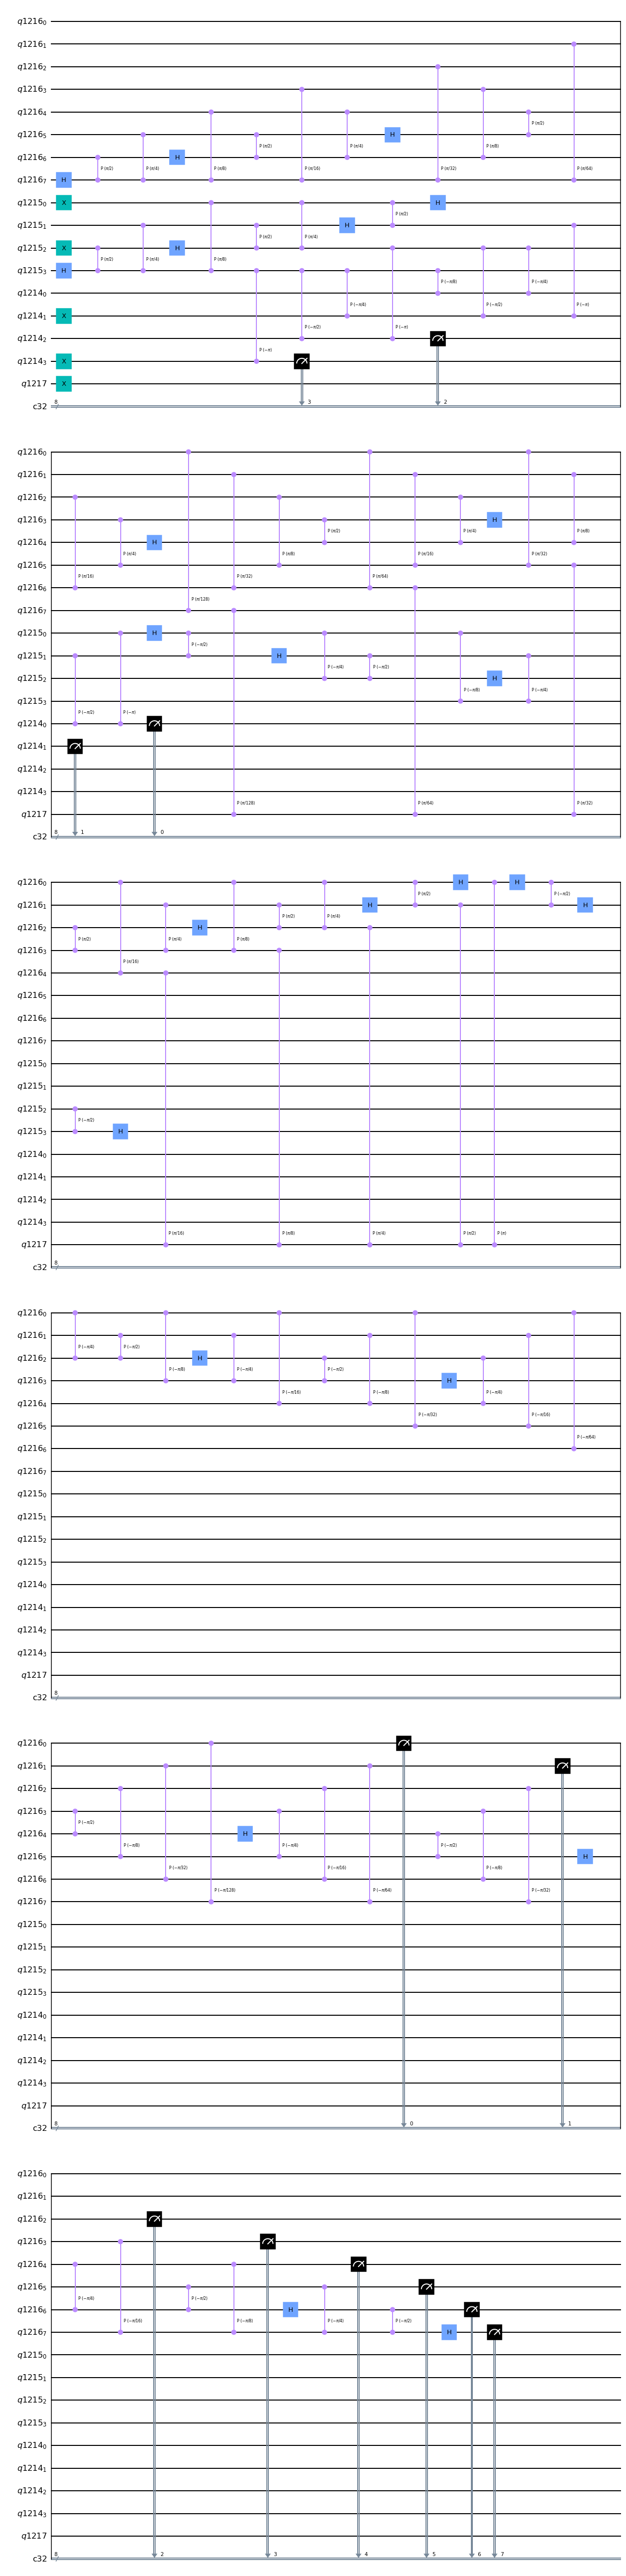

In [37]:
circ.draw('mpl')